<a href="https://colab.research.google.com/github/vanderbilt-ml/50-smith-mlproj-pokemon/blob/main/Pokemon_classifier_project_overview.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Background
I tend to spend quite a lot of time playing video games and as a result, I direct a lot of my personal projects towards them. I also spend a lot of time watching videos describing assistant tools for games that help speed up monotonous tasks or increase quality of life. I have attempted a few times to make some smaller tools, such as one that helps build an optimal path for collecting a set of items, and a Wordle solver using a SAT solver. For this project I wanted to try something a little bit less practical and more fun that I can use for Pokemon.

#Project Description
The goal of this project is to create an image recognition classification based application that can identify data values about pokemon based on features it identifies from their images. Pokemon has large amount of discrete data about each individual pokemon that can be easily quantified as metadata for training with their images. The initial goal for this project is for it to begin to recognize pokemon types based on their physical appearances. 

#Performance Metric
For performance metrics, the primary focus is just on accuracy, with a goal of at least 50% accuracy. If I were to find a good single value to test classification against as positive or negative, a confusion matrix may be used as well.

In [40]:
#tables and visualizations
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import os


#machine learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer, StandardScaler
from sklearn import config_context
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from skimage.io import imread
from skimage.transform import resize

In [41]:
from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

worksheet = gc.open('data_dictionary').get_worksheet(1)

# get_all_values gives a list of rows.
rows = worksheet.get_all_values()
print(rows)

# Convert to a DataFrame and render.
import pandas as pd
data_frame = pd.DataFrame.from_records(rows)
data_frame

[['Ndex', 'Pokémon', 'Type1', 'Type2'], ['#001', 'Bulbasaur', 'Grass', 'Poison'], ['#002', 'Ivysaur', 'Grass', 'Poison'], ['#003', 'Venusaur', 'Grass', 'Poison'], ['#004', 'Charmander', 'Fire', ''], ['#005', 'Charmeleon', 'Fire', ''], ['#006', 'Charizard', 'Fire', 'Flying'], ['#007', 'Squirtle', 'Water', ''], ['#008', 'Wartortle', 'Water', ''], ['#009', 'Blastoise', 'Water', ''], ['#010', 'Caterpie', 'Bug', ''], ['#011', 'Metapod', 'Bug', ''], ['#012', 'Butterfree', 'Bug', 'Flying'], ['#013', 'Weedle', 'Bug', 'Poison'], ['#014', 'Kakuna', 'Bug', 'Poison'], ['#015', 'Beedrill', 'Bug', 'Poison'], ['#016', 'Pidgey', 'Normal', 'Flying'], ['#017', 'Pidgeotto', 'Normal', 'Flying'], ['#018', 'Pidgeot', 'Normal', 'Flying'], ['#019', 'Rattata', 'Normal', ''], ['#020', 'Raticate', 'Normal', ''], ['#021', 'Spearow', 'Normal', 'Flying'], ['#022', 'Fearow', 'Normal', 'Flying'], ['#023', 'Ekans', 'Poison', ''], ['#024', 'Arbok', 'Poison', ''], ['#025', 'Pikachu', 'Electric', ''], ['#026', 'Raichu', 

,0,1,2,3
0,Ndex,Pokémon,Type1,Type2
1,#001,Bulbasaur,Grass,Poison
2,#002,Ivysaur,Grass,Poison
3,#003,Venusaur,Grass,Poison
4,#004,Charmander,Fire,
...,...,...,...,...
805,#805,Stakataka,Rock,Steel
806,#806,Blacephalon,Fire,Ghost
807,#807,Zeraora,Electric,
808,#808,Meltan,Steel,


In [48]:

def resize_all(src, pklname, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})pokemon images in rgb'.format(int(width), int(height))
    data['type1'] = []
    data['type2'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
 
    for file in os.listdir(src):
        if file[-3:] in {'jpg', 'png'}:
            im = imread(os.path.join(src, file))
            im = resize(im, (width, height)) #[:,:,::-1]
            data['type1'].append(data_frame.iloc[int(file[:-4]),2])
            data['type2'].append(data_frame.iloc[int(file[:-4]),3])
            data['filename'].append(file)
            data['data'].append(im)
 
    joblib.dump(data, pklname)

In [49]:
data_path = "/content/drive/MyDrive/pokemon/pokemon"

include = os.listdir(data_path)
base_name = 'pokemon'
width = 256
 
resize_all(src=data_path, pklname=base_name, width=width)

In [51]:
from collections import Counter

data = joblib.load(f'{base_name}_{width}x{width}px.pkl')

print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('type1:', np.unique(data['type1']))
print('type2:', np.unique(data['type2']))

number of samples:  721
keys:  ['description', 'type1', 'type2', 'filename', 'data']
description:  resized (256x256)pokemon images in rgb
image shape:  (256, 256, 4)
type1: ['Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']
type2: ['' 'Bug' 'Dark' 'Dragon' 'Electric' 'Fairy' 'Fighting' 'Fire' 'Flying'
 'Ghost' 'Grass' 'Ground' 'Ice' 'Normal' 'Poison' 'Psychic' 'Rock' 'Steel'
 'Water']


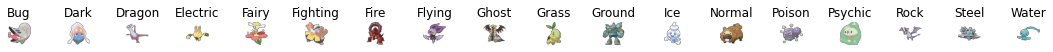

In [53]:
labels = np.unique(data['type1'])

# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['type1'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)


In [56]:
X = np.array(data['data'])
y = np.array(data['type1'])
 
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    shuffle=True,
    random_state=42,
    stratify=y
)

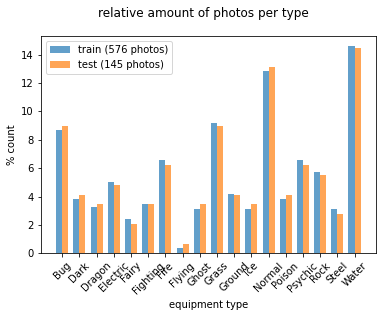

In [58]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

In [59]:
from sklearn.linear_model import SGDClassifier


sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train, y_train)

ValueError: ignored